In [2]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport VQE, GroupingAlgorithm, HEEM_VQE_Functions, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from utils import *
from qiskit import IBMQ
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.test.mock import FakeVigo
import os
from joblib import Parallel, delayed
from IPython.display import display, clear_output
from GroupingAlgorithm import grouping_shuffle
from tqdm.notebook import tqdm_notebook

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [4]:
import contextlib
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()   

In [5]:
def molecule(d, quantum_instance, conectivity, basis):
    E = np.zeros(4)

    def callback(evals, params):  
        display("{}, {}".format(len(evaluations),evals))
        clear_output(wait=True)
        parameters.append(params)
        evaluations.append(evals)

    parameters  = []
    evaluations = []


    qubit_op, init_state = LiH(d, initial_state=True)
#     qubit_op = grouping_shuffle(qubit_op, basis, coupling_map)
    
    num_qubits = qubit_op.num_qubits

    # Exact energy
    E[0] = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op).eigenvalue.real
    print('Exact energy: {}'.format(E[0]))

    optimizer = SPSA(maxiter=maxiter, last_avg=1)
    ansatz = init_state.compose(EfficientSU2(num_qubits, ['ry', 'rz'], entanglement='linear', reps=1))
    num_var = ansatz.num_parameters
    initial_params = np.random.rand(num_var)


    solver_TPB = VQE(ansatz, optimizer, initial_params, grouping='TPB', quantum_instance=quantum_instance,
                     callback=callback, order=basis)
    solver_ENT = VQE(ansatz, optimizer, initial_params, grouping='Entangled', quantum_instance=quantum_instance,
                     callback=callback, order=basis)
    solver_HEEM = VQE(ansatz, optimizer, initial_params, grouping='Entangled', conectivity=conectivity,
                      quantum_instance=quantum_instance, callback=callback, order=basis)


    print('-' * 100)
    print('Computing TPB:')
    E[1] = solver_TPB.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

    print('-' * 100)
    print('Computing ENT:')
    E[2] = solver_ENT.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

    print('-' * 100)
    print('Computing HEEM:')
    E[3] = solver_HEEM.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

    return E, evaluations

In [6]:
def molecule_potentials_comparison(distances, quantum_instance, conectivity, basis, file_name_out):
    E_EXACT = np.zeros_like(distances)
    E_TPB = np.zeros_like(distances)
    E_ENT = np.zeros_like(distances)
    E_HEEM = np.zeros_like(distances)
    evaluations = []


    with tqdm_joblib(tqdm_notebook(desc="Computing", total=len(distances))) as progress_bar:
        results = Parallel(n_jobs=24)(delayed(molecule)(d, quantum_instance, conectivity, basis) for d in distances)
        
    for i in range(len(distances)):
        E_EXACT[i] = results[i][0][0]
        E_TPB[i] = results[i][0][1]
        E_ENT[i] = results[i][0][2]
        E_HEEM[i] = results[i][0][3]
        evaluations.append(results[i][1])

#     Save results
    np.savez(file_name_out, distances=distances, E_EXACT=E_EXACT, E_TPB=E_TPB, E_ENT=E_ENT, E_HEEM=E_HEEM, evaluations=evaluations)

    return E_EXACT, E_TPB, E_ENT, E_HEEM, evaluations

In [7]:
distances = np.linspace(0.5, 5, 100)
backend = Aer.get_backend('qasm_simulator')
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
NUM_SHOTS = 2 ** 13  # Number of shots for each circuit
maxiter = 300
qi = QuantumInstance(backend=backend, coupling_map=coupling_map, noise_model=noise_model, basis_gates=basis_gates, shots=NUM_SHOTS)
basis = [4, 6, 7, 8, 9, 5, 3, 2, 1]

In [15]:
coupling_map

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]

In [8]:
file_name_out = '../data/LiH_' + qi.backend_name + '_NUM_SHOTS=' + str(NUM_SHOTS) + '_dist=' + str(distances[0]) + '_to_' + str(distances[-1])

In [8]:
results = molecule_potentials_comparison(distances, qi, coupling_map, basis, file_name_out)

Computing:   0%|          | 0/100 [00:00<?, ?it/s]

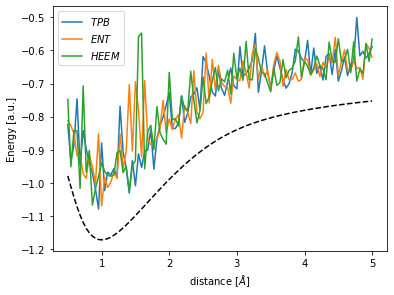

In [9]:
data = np.load(file_name_out + '.npz')

E_EXACT = data['E_EXACT']
E_TPB = data['E_TPB']
E_ENT = data['E_ENT']
E_HEEM = data['E_HEEM']
evaluations = data['evaluations']

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4.5))
ax.set_xlabel(r'distance [$\AA$]')
ax.set_ylabel('Energy [a.u.]')

ax.plot(distances, E_TPB)
ax.plot(distances, E_ENT)
ax.plot(distances, E_HEEM)
ax.plot(distances, E_EXACT, color='black', linestyle='--')

ax.legend(['$TPB$', '$ENT$', '$HEEM$'])

# plt.savefig("../Figures/E vs d.pdf")

In [10]:
print(np.mean(E_EXACT - E_TPB))
print(np.mean(E_EXACT - E_ENT))
print(np.mean(E_EXACT - E_HEEM))

-0.16539265098097683
-0.1651958924429035
-0.17025973693426644


In [13]:
np.argmax(E_HEEM)

24

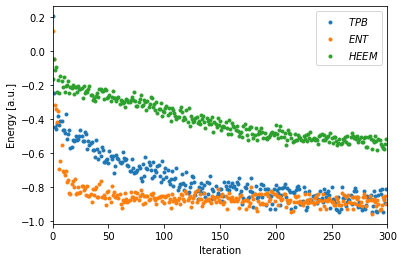

In [14]:
index = 24
evaluation = evaluations[index]
maxiter = int((len(evaluation) / 3 - 1 - 50) / 2)

fig, ax = plt.subplots()

labels = ['$TPB$', '$ENT$', '$HEEM$']
for i in range(3):
    ax.plot(evaluation[50 * (i + 1) + 2 * maxiter * i : 50 * (i + 1) + 2 * maxiter * (i + 1)][::2], '.', label=labels[i])

ax.set_xlim([0, maxiter])
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy [a.u.]')
ax.legend()

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table